# RVCGP 
## Simple two node function

Test, wheter RVCGP is able to find exact solution, to simple two node function with prescription:
$$
f(x) = x_0*x_1 + x_0
$$

Generate train data:

In [2]:
import numpy as np

def target_function(X):
    return X[:,0] * X[:,1] + X[:,0]

_X = np.linspace(-5, 5, 20)
x, y = np.meshgrid(_X, _X)
X_train = np.dstack((x, y)).reshape(400, 2)
X_train = np.c_[X_train, np.ones(len(X_train))]
y_train = target_function(X_train)

Add tengp into the mix.

In [5]:
import tengp

def pdivide(x, y):
    return np.divide(x, y, out=np.copy(x), where=x!=0)

funset = tengp.FunctionSet()
funset.add(np.add, 2)
funset.add(np.subtract, 2)
funset.add(np.multiply, 2)
funset.add(pdivide, 2)

rv_params = tengp.Parameters(3, 1, 1, 2, funset, real_valued=True)
params = tengp.Parameters(3, 1, 1, 2, funset)

bounds = tengp.individual.IndividualBuilder(params).create().bounds[:]
bounds

[3, 2, 2, 3, 3, 3, 4]

In [69]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
from sklearn.metrics import mean_squared_error

# Fitness landscape according to input genes values of first node, 0.5add + 0.5subtract

In [67]:
Xr = np.linspace(0, 2, num=40);
X_points, Y_points = np.meshgrid(Xr, Xr)

Z = []
for x_v, y_v in zip(X_points, Y_points):
    for x_, y_ in zip(x_v, y_v):
        genes = [1.5, x_, y_, 2, 3, 1, 3]
        individual = rv_params.individual_class(genes, bounds, rv_params)
        output = individual.transform(X_train)
        individual.fitness = mean_squared_error(output, y_train)
        Z.append(individual.fitness)

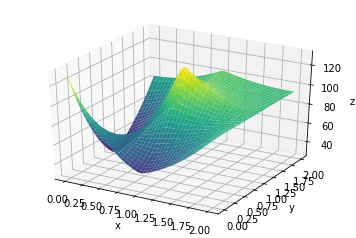

In [70]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X_points, Y_points, np.array(Z).reshape(40, 40),rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

# Optimization using PSO

In [158]:
import pygmo as pg

vectors = []
n_actives = []

class cost_function:
    def __init__(self, X, Y, params, bounds):
        self.params = params
        self.bounds = bounds
        self.X = X
        self.Y = Y
    
    def fitness(self, x):
        vectors.append(x)
        x[-1] = round(x[-1])
        
        individual = tengp.individual.NPIndividual(
            list(x), self.bounds, self.params
        )
        
        pred = individual.transform(self.X)
        
        try:
            return [mean_squared_error(pred, self.Y)]
        except ValueError:
            return [10000000000]
        
    def get_bounds(self):
        lower = [0]*len(self.bounds)
        return (lower, [b for b in self.bounds])

In [161]:
pg.set_global_rng_seed(0)
prob = pg.problem(cost_function(X_train, y_train, rv_params, bounds))

algo = pg.algorithm(pg.pso(
    gen=100,
    eta1=0.01
))
algo.set_verbosity(1)
pop = pg.population(prob, 50)
pop = algo.evolve(pop)
print(pop.champion_f[0])
print(pop.champion_x)

4.162791877234254e-06
[1.99996683e+00 3.54523204e-05 1.49981761e+00 1.66135144e-04
 2.99986742e+00 2.99991806e+00 3.99067362e+00]


In [132]:
last_genes = [x[-1] for x in vectors]

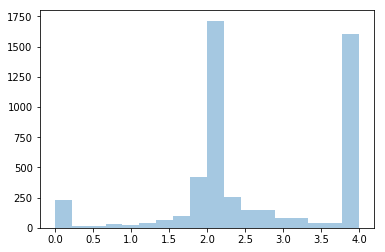

In [138]:
import seaborn as sns

sns.distplot(last_genes, kde=False)

In [150]:
genes = [2, 0, 1, 0, 0, 3, 4]
rv_individual = tengp.individual.NPIndividual(
    genes, bounds, rv_params
)
rv_pred = rv_individual.transform(X_train)
mean_squared_error(rv_pred, y_train)

2.39612840693988e-30

In [151]:
genes = [2, 0, 1, 0, 0, 3, 4]
individual = tengp.individual.NPIndividual(
    genes, bounds, params
)
pred = individual.transform(X_train)
mean_squared_error(pred, y_train)

0.0